In [1]:
#https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6
import pandas as pd
from sentence_transformers import SentenceTransformer
import umap
import hdbscan
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import nltk
import pickle


2023-03-22 23:37:05.564533: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-22 23:37:18.047597: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-22 23:37:18.047770: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-03-22 23:37:18.047780: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
df_pedidos = pd.read_pickle('dados/pedidos_texto.pkl') #.sample(1000)
df_pedidos_txt = pd.DataFrame({'IdPedido': df_pedidos['IdPedido'], 'TextoPedidoAgrupado': df_pedidos['ResumoSolicitacao'].fillna('') + ' ' + df_pedidos['DetalhamentoSolicitacao'].fillna('')})
df_pedidos_txt.head()


,IdPedido,TextoPedidoAgrupado
0,1678719,consultar meu cpf . no spc e serasa Consulta d...
1,1678723,Esclarecimentos sobre seguro de risco de incên...
2,1678726,"SALDO PASEP Bom dia, necessito do saldo do P..."
3,1678739,cópia termo de convenio em MCIDADES e prefeitu...
4,1678747,cópia termo de convenio em MCIDADES e prefeitu...


In [15]:
enunciados = pd.read_excel('dados/enunciados.xlsx', sheet_name=0)
enunciados

,idEnunciado,nrEnunciado,enunciado,detalhamento,idGrupoEnunciado
0,1,1/2023,Enunciado CGU n. 1/2023 - Registros de entrada...,Os registros de entrada e saída de pessoas em ...,1
1,2,2/2023,Enunciado CGU n. 2/2023 - Registros de entrada...,Os registros de entrada e saída de pessoas em ...,1
2,3,3/2023,Enunciado CGU n. 3/2023 - Procedimentos discip...,Aplicam-se aos pedidos de acesso a processos a...,1
3,4,4/2023,Enunciado CGU n. 4/2023 - Segurança do Preside...,"Durante o mandato presidencial, a classificaçã...",2
4,5,5/2023,Enunciado CGU n. 5/2023 - Sigilo de licitações...,"Informações sobre licitações, contratos e gast...",2
5,6,6/2023,Enunciado CGU n. 6/2023 - Abertura de informaç...,Transcorrido o prazo de classificação da infor...,3
6,7,7/2023,Enunciado CGU n. 7/2023 - Títulos acadêmicos e...,Informações sobre currículos de agentes públic...,1
7,8,8/2023,Enunciado CGU n. 8/2023 - Provas e concursos p...,A divulgação de documentos e informações relac...,1
8,9,9/2023,"Enunciado CGU n. 9/2023 - Telegramas, despacho...","Os telegramas, despachos e circulares telegráf...",1
9,10,10/2023,Enunciado CGU n. 10/2023 - Informações finance...,Informações referentes a valores de benefícios...,1


In [19]:
enunciados['resumo'] = enunciados['enunciado'].apply(lambda txt: txt.split('-')[1].strip() + '.')

In [21]:
enunciados['txtAgrupado'] = enunciados['resumo'] + ' ' + enunciados['detalhamento']
enunciados[['idEnunciado', 'txtAgrupado']]


,idEnunciado,txtAgrupado
0,1,Registros de entrada e saída de prédios públic...
1,2,Registros de entrada e saída de residências of...
2,3,Procedimentos disciplinares de militares. Apli...
3,4,Segurança do Presidente da República e familia...
4,5,"Sigilo de licitações, contratos e gastos gover..."
5,6,Abertura de informações desclassificadas. Tran...
6,7,Títulos acadêmicos e currículos de agentes púb...
7,8,Provas e concursos públicos. A divulgação de d...
8,9,"Telegramas, despachos telegráficos e as circul..."
9,10,Informações financeiras a respeito de programa...


In [23]:
#model = SentenceTransformer('rufimelo/Legal-BERTimbau-sts-base-ma-v2')
#model = SentenceTransformer('nreimers/MiniLM-L6-H384-uncased')
model = SentenceTransformer('rufimelo/Legal-BERTimbau-large-GPL-sts')


In [24]:
embeddings_enunciados = model.encode(list(enunciados['txtAgrupado']), show_progress_bar=True)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
embeddings = model.encode(list(df_pedidos_txt['TextoPedidoAgrupado']), show_progress_bar=True)


Batches:   0%|          | 0/21969 [00:00<?, ?it/s]

In [5]:
embeddings.shape


(703004, 384)

In [9]:
np.save('embeddings_MiniLM-L6-H384-uncased_all_ai.emb', embeddings)


In [3]:
embeddings = np.load('embeddings_MiniLM-L6-H384-uncased_all_ai.emb.npy')

In [ ]:
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(embeddings)

In [ ]:
umap_embeddings.shape

In [68]:
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

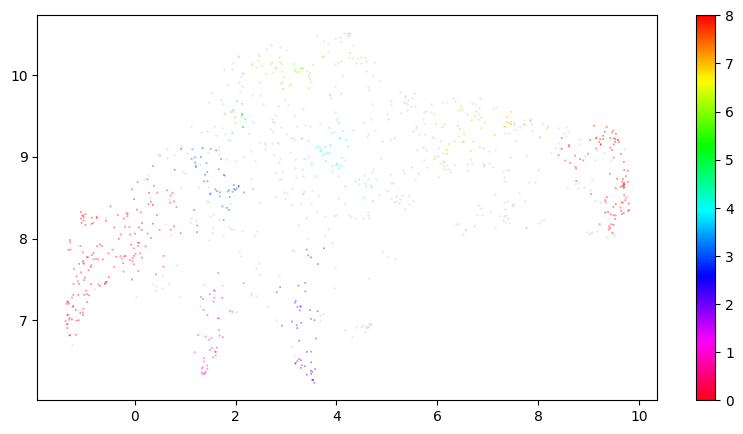

In [69]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(10, 5))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

In [70]:
df_pedidos_txt['Topic'] = cluster.labels_
docs_per_topic = df_pedidos_txt.groupby(['Topic'], as_index = False).agg({'TextoPedidoAgrupado': ' '.join})


In [71]:
df_pedidos_txt['Topic'].value_counts()

-1    495
 0    164
 8     92
 2     47
 1     42
 3     41
 7     36
 4     34
 6     34
 5     15
Name: Topic, dtype: int64

In [72]:
docs_per_topic

,Topic,TextoPedidoAgrupado
0,-1,Como obter as Normais Climatológicas (Evapotra...
1,0,Acesso ao meu INSS Não consigo acessar o meu ...
2,1,Declaração final de Espolio de 2019 Como faço ...
3,2,"Cópia de Pareceres Prezados, Gostaria, por ge..."
4,3,RELAÇÃO ENTIDADES FECHADAS DE PREVIDÊNCIA COMP...
5,4,Solicitação de declaração Solicitação para qu...
6,5,Informações sobre a Unidade de Conservação PAR...
7,6,"info Solicito, por favor, o custo mensal, mes ..."
8,7,Ações orçamentárias de programas alimentares r...
9,8,eu só tenho só você para perguntar se fiz dire...


In [73]:
def c_tf_idf(documents, m, ngram_range=(1, 1), stopwords="english"):
    count = CountVectorizer(ngram_range=ngram_range, stop_words=stopwords).fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes


In [74]:
stopwords = nltk.corpus.stopwords.words('portuguese')
tf_idf, count = c_tf_idf(docs_per_topic.TextoPedidoAgrupado.values, m=df_pedidos_txt.shape[0], stopwords=stopwords)


In [75]:
tf_idf.shape

(10118, 10)

In [63]:
count

CountVectorizer(stop_words=['a', 'à', 'ao', 'aos', 'aquela', 'aquelas',
                            'aquele', 'aqueles', 'aquilo', 'as', 'às', 'até',
                            'com', 'como', 'da', 'das', 'de', 'dela', 'delas',
                            'dele', 'deles', 'depois', 'do', 'dos', 'e', 'é',
                            'ela', 'elas', 'ele', 'eles', ...])

In [76]:
top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)


,Topic,Size
0,-1,0
1,0,0
2,1,0
3,2,0
4,3,0
5,4,0
6,5,0
7,6,0
8,7,0


In [77]:
top_n_words

{-1: [('dados', 0.00902704897447434),
  ('gostaria', 0.007736957673751313),
  ('sobre', 0.007424783749963667),
  ('informações', 0.006895365515709053),
  ('número', 0.006686987149455712),
  ('saber', 0.0066631330145672215),
  ('informação', 0.00661153543444811),
  ('brasil', 0.006595607053390335),
  ('solicito', 0.006490246181026375),
  ('lei', 0.006451919951484619),
  ('ano', 0.006392833280821476),
  ('instituição', 0.006321906290587887),
  ('2015', 0.006201051466531209),
  ('desde', 0.006063288738474379),
  ('prezados', 0.00596892520632388),
  ('acesso', 0.005879798557161731),
  ('solicitação', 0.005867747264211789),
  ('processo', 0.005813365293085424),
  ('caso', 0.005743943295288199),
  ('pesquisa', 0.005685868149474427)],
 0: [('saber', 0.028629094373384244),
  ('gostaria', 0.023043028923184935),
  ('vagos', 0.022304195615106492),
  ('cargos', 0.02180927954876036),
  ('número', 0.01882490632329545),
  ('solicito', 0.01777976693863591),
  ('declaração', 0.017015635060859142),
  ('